### Importing libaries 

In [1]:
#data analysis and wrangling
import numpy as np 
import pandas as pd 

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
plt.style.use('ggplot')

#machine learning 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

#neural network 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

#evaluation 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [2]:
#load and reading the data
df = pd.read_csv('fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data cleaning

In [3]:
#check the shape of the data
df.shape

(6362620, 11)

In [4]:
#check for null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
#checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
#checking duplicate values
df.duplicated().sum()   

0

In [7]:
#renaming columns
df = df.rename(columns={'nameOrig': 'origin', 'oldbalanceOrg': 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest': 'destination', 'oldbalanceDest': 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud': 'isfraud'})
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   step                  int64  
 1   type                  object 
 2   amount                float64
 3   origin                object 
 4   sender_old_balance    float64
 5   sender_new_balance    float64
 6   destination           object 
 7   receiver_old_balance  float64
 8   receiver_new_balance  float64
 9   isfraud               int64  
 10  isFlaggedFraud        int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
#droping columns which are not required
df = df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

In [9]:
#checking the data 
cols = df.columns.tolist()
new_position = 3
# moving the column to the new position
cols.insert(new_position, cols.pop(cols.index('destination')))
df = df[cols]

In [10]:
df.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


### Exploratory data analysis

In [11]:
#showing a statistical summary of the data for amount, sender_old_balance and receiver_old_balance
summary_stats = df[['amount', 'sender_old_balance', 'receiver_old_balance', 'sender_new_balance', 'receiver_new_balance', 'isfraud']].describe()
summary_stats = summary_stats.transpose()
summary_stats

,count,mean,std,min,25%,50%,75%,max
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
sender_old_balance,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
receiver_old_balance,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
sender_new_balance,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
receiver_new_balance,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isfraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00


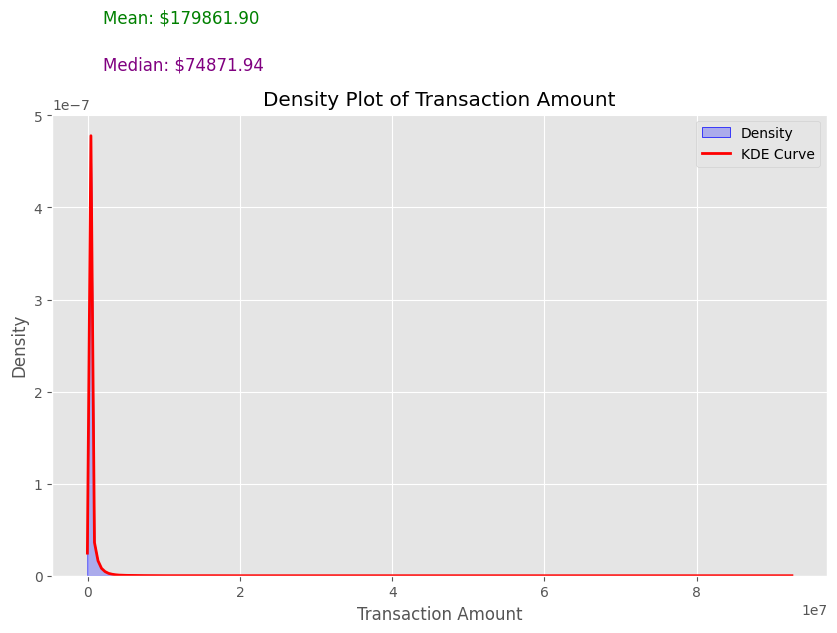

In [12]:
# Plotting a density plot for the amount column
plt.figure(figsize=(10, 6))

# Create a density plot with more bins and a color palette
sns.kdeplot(df['amount'], shade=True, color='blue', label='Density')
sns.kdeplot(df['amount'], color='red', lw=2, label='KDE Curve')

# Add labels and title
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.title('Density Plot of Transaction Amount')

# Include summary statistics (mean and median) as text on the plot
mean_amount = df['amount'].mean()
median_amount = df['amount'].median()
plt.text(2000000, 0.0000006, f'Mean: ${mean_amount:.2f}', fontsize=12, color='green')
plt.text(2000000, 0.00000055, f'Median: ${median_amount:.2f}', fontsize=12, color='purple')

# Add a legend
plt.legend()

plt.show()

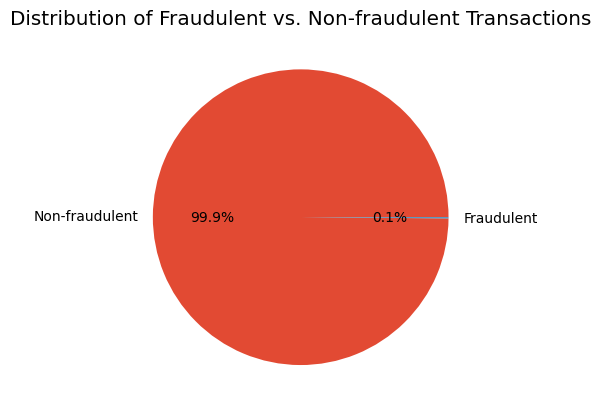

In [13]:
#ploting a pie chart for fraudulent vs. non-fraudulent transactions
fraud_counts = df['isfraud'].value_counts()
plt.pie(fraud_counts, labels=['Non-fraudulent', 'Fraudulent'], autopct='%1.1f%%')
plt.title('Distribution of Fraudulent vs. Non-fraudulent Transactions')
plt.show()


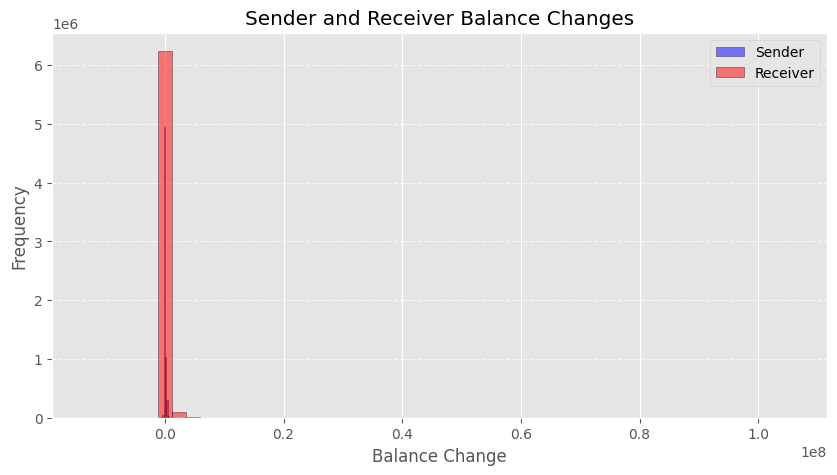

In [14]:
# Calculate balance changes
df['sender_balance_change'] = df['sender_new_balance'] - df['sender_old_balance']
df['receiver_balance_change'] = df['receiver_new_balance'] - df['receiver_old_balance']

# Plot side-by-side histograms
plt.figure(figsize=(10, 5))
plt.hist(df['sender_balance_change'], bins=50, alpha=0.5, color='blue', label='Sender', edgecolor='k')
plt.hist(df['receiver_balance_change'], bins=50, alpha=0.5, color='red', label='Receiver', edgecolor='k')
plt.xlabel('Balance Change')
plt.ylabel('Frequency')
plt.title('Sender and Receiver Balance Changes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

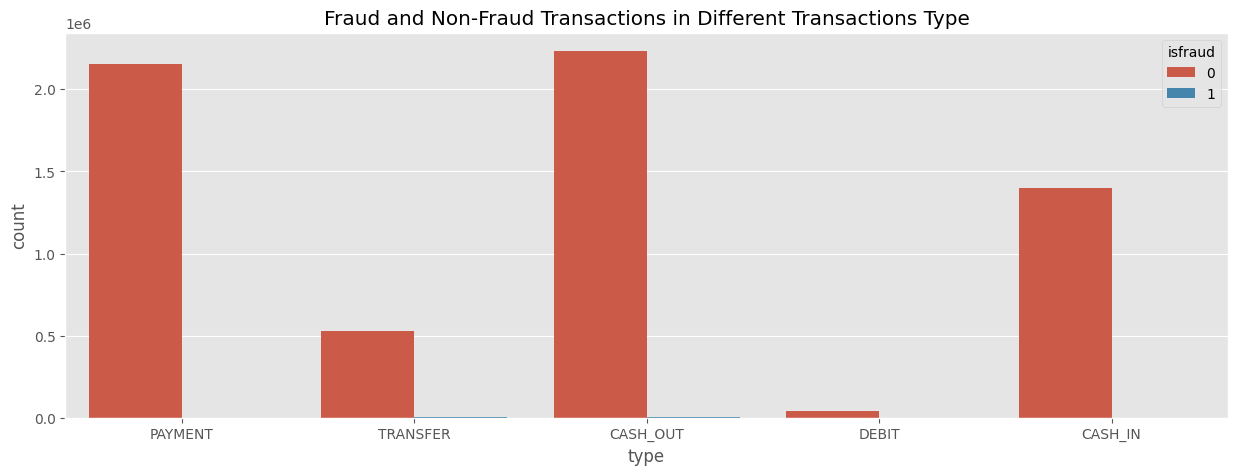

In [15]:
#make a barplot to see the fraud and non fraud transactions in different transactions type
plt.figure(figsize=(15,5))
sns.countplot(x='type', hue='isfraud', data=df)
plt.title('Fraud and Non-Fraud Transactions in Different Transactions Type')
plt.show()

In [16]:
fraud_trans = df[df['isfraud'] == 1]
valid_trans = df[df['isfraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Has the receiving accoung used for cashing out?')
trans_transfer.destination.isin(trans_cashout.origin).any()

Has the receiving accoung used for cashing out?


False

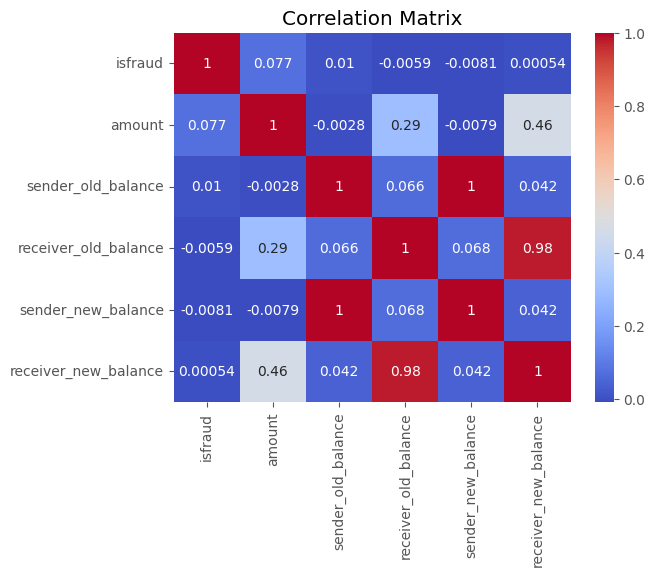

In [17]:
correlation_matrix = df[['isfraud', 'amount', 'sender_old_balance', 'receiver_old_balance', 'sender_new_balance', 'receiver_new_balance']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [18]:
transfer_fraud = df[((df['type']=='TRANSFER') & df['isfraud']==1)]
transfer_fraud['origin'].value_counts()

origin
C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: count, Length: 4097, dtype: int64

In [19]:
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()

destination
C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: count, Length: 4091, dtype: int64

### feature enginerring

In [20]:
df = df.copy()
df['type2'] = np.nan
df.loc[df.origin.str.contains('C') & df.destination.str.contains('C'), 'type2'] = 'CC'
df.loc[df.origin.str.contains('C') & df.destination.str.contains('M'), 'type2'] = 'CM'
df.loc[df.origin.str.contains('M') & df.destination.str.contains('C'), 'type2'] = 'MC'
df.loc[df.origin.str.contains('M') & df.destination.str.contains('C'), 'type2'] = 'MM'

In [21]:
cols = df.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
df = df[cols]

In [22]:
df.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

In [23]:
df.head()

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud,sender_balance_change,receiver_balance_change
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0,-9839.64,0.0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0,-1864.28,0.0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1,-181.00,0.0
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1,-181.00,-21182.0
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0,-11668.14,0.0


In [24]:
fraud_trans = df[df['isfraud'] == 1]
valid_trans = df[df['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 type2
CC    8213
Name: count, dtype: int64 

Number of valid transactions according to type are below:
 type2
CC    4202912
CM    2151495
Name: count, dtype: int64


In [25]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()

Text(0.5, 1.0, 'Valid')

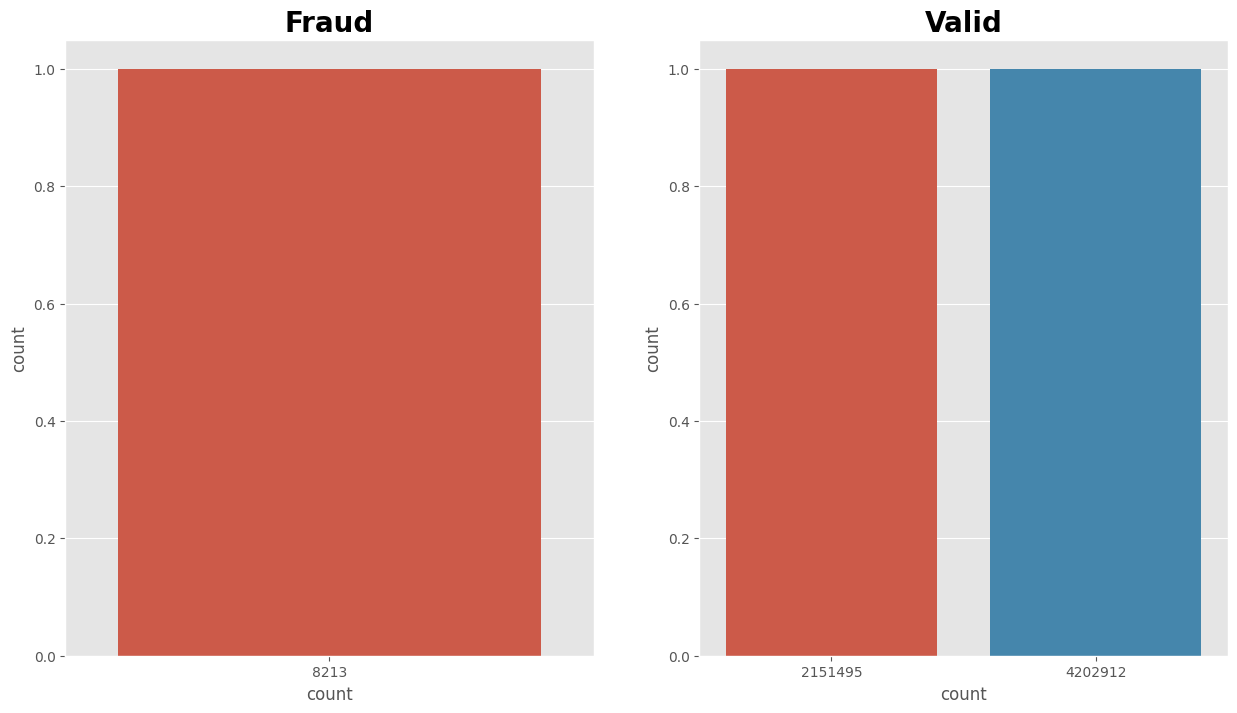

In [26]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr)
plt.title('Fraud',fontweight="bold", size=20)
plt.subplot(1,2,2)
sns.countplot(x = va)
plt.title('Valid',fontweight="bold", size=20)

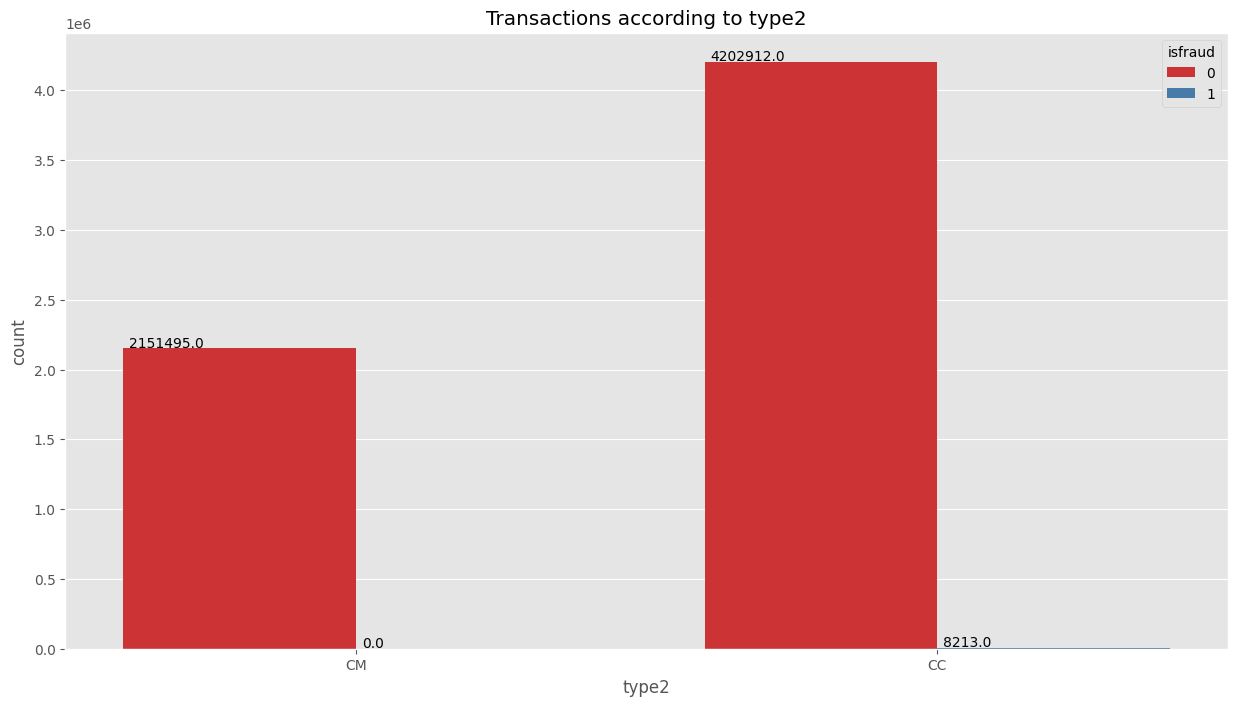

In [27]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df, x = "type2", hue="isfraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

### Data preprocessing

In [28]:
#doing one hot encoding for type and type2 columns
def onehot_encode(df,column):
    df=df.copy()
    dummies=pd.get_dummies(df[column],prefix=column)
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    return df

In [29]:
df = onehot_encode(df, ['type', 'type2'])

In [30]:
df.head()   

,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud,sender_balance_change,receiver_balance_change,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,9839.64,170136.0,160296.36,0.0,0.0,0,-9839.64,0.0,False,False,False,True,False,False,True
1,1864.28,21249.0,19384.72,0.0,0.0,0,-1864.28,0.0,False,False,False,True,False,False,True
2,181.00,181.0,0.00,0.0,0.0,1,-181.00,0.0,False,False,False,False,True,True,False
3,181.00,181.0,0.00,21182.0,0.0,1,-181.00,-21182.0,False,True,False,False,False,True,False
4,11668.14,41554.0,29885.86,0.0,0.0,0,-11668.14,0.0,False,False,False,True,False,False,True


In [31]:
#naming the columns X and y for training and testing
X = df.drop('isfraud', axis = 1)
y=df['isfraud']
#splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = df['isfraud'])
#scaling the data using StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [32]:
X_train.shape, X_test.shape

((4453834, 14), (1908786, 14))

### Model building 

In [33]:
#building first neural network model
epochs = 10
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))

In [34]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=epochs, validation_data=(np.array(X_test), np.array(y_test)), batch_size=64)

Epoch 1/10
69592/69592 [==============================] - 88s 1ms/step - loss: 0.0217 - accuracy: 0.9960 - val_loss: 0.0040 - val_accuracy: 0.9992
Epoch 2/10
69592/69592 [==============================] - 88s 1ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 3/10
69592/69592 [==============================] - 87s 1ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 4/10
69592/69592 [==============================] - 84s 1ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9992
Epoch 5/10
69592/69592 [==============================] - 84s 1ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9992
Epoch 6/10
69592/69592 [==============================] - 84s 1ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 7/10
69592/69592 [==============================] - 84s 1ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0

In [37]:
# Save the model to a file
model.save("logreg_model.h5")

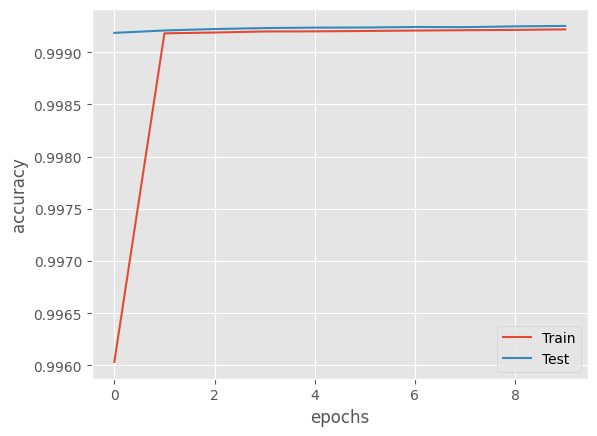

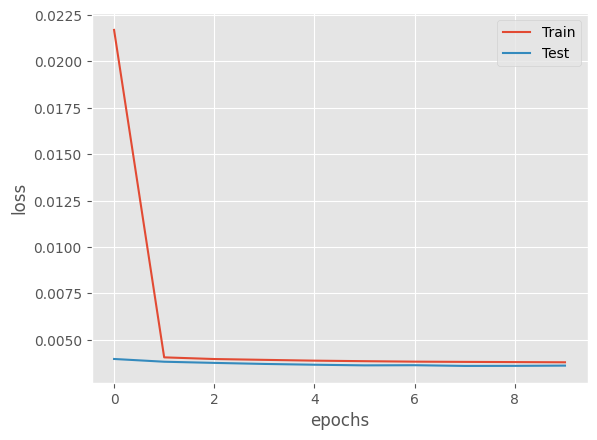

In [38]:
# visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

### Tuned model

In [39]:
weights_assigned = {0: 1, 1: 770}
epochs = 10
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

In [40]:
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=epochs, validation_data=(np.array(X_test), np.array(y_test)), batch_size=64, class_weight=weights_assigned)

Epoch 1/10
69592/69592 [==============================] - 92s 1ms/step - loss: 0.5566 - accuracy: 0.9177 - val_loss: 0.2564 - val_accuracy: 0.9640
Epoch 2/10
69592/69592 [==============================] - 92s 1ms/step - loss: 0.5155 - accuracy: 0.9467 - val_loss: 0.3051 - val_accuracy: 0.9435
Epoch 3/10
69592/69592 [==============================] - 93s 1ms/step - loss: 0.5162 - accuracy: 0.9468 - val_loss: 0.2941 - val_accuracy: 0.9505
Epoch 4/10
69592/69592 [==============================] - 92s 1ms/step - loss: 0.5165 - accuracy: 0.9468 - val_loss: 0.2892 - val_accuracy: 0.9480
Epoch 5/10
69592/69592 [==============================] - 92s 1ms/step - loss: 0.5153 - accuracy: 0.9466 - val_loss: 0.2918 - val_accuracy: 0.9462
Epoch 6/10
69592/69592 [==============================] - 93s 1ms/step - loss: 0.5169 - accuracy: 0.9468 - val_loss: 0.3087 - val_accuracy: 0.9372
Epoch 7/10
69592/69592 [==============================] - 92s 1ms/step - loss: 0.5150 - accuracy: 0.9465 - val_loss: 0

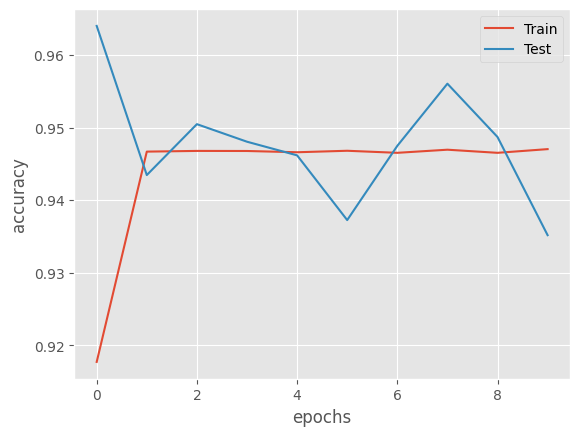

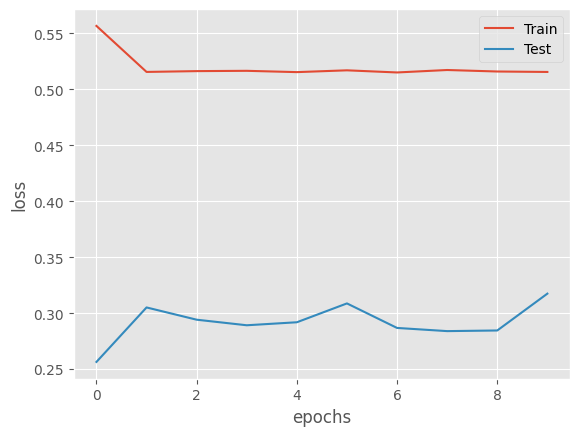

In [42]:
#visualize the results for tuned model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [45]:
#save new model
model.save("logreg_model2.fixed.")

INFO:tensorflow:Assets written to: logreg_model2.fixed.\assets


INFO:tensorflow:Assets written to: logreg_model2.fixed.\assets


### Evaluating the two models

In [33]:
# Load the first model
model1 = keras.models.load_model('logreg_model.h5')

# Load the second model
model2 = keras.models.load_model('logreg_model2.fixed')

In [34]:
# Make predictions with the models
y_pred1 = model1.predict(X_test)
y_pred1 = (y_pred1 > 0.5)

y_pred2 = model2.predict(X_test)
y_pred2 = (y_pred2 > 0.5)


59650/59650 [==============================] - 46s 773us/step


In [35]:
# Evaluate the models using accuracy and classification report
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)

report1 = classification_report(y_test, y_pred1)
report2 = classification_report(y_test, y_pred2)

# Print the evaluation results
print("Model 1 - Accuracy:", accuracy1)
print("Model 2 - Accuracy:", accuracy2)

print("\nModel 1 - Classification Report:\n", report1)
print("\nModel 2 - Classification Report:\n", report2)

Model 1 - Accuracy: 0.9992534521942219
Model 2 - Accuracy: 0.935396634300545

Model 1 - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.91      0.47      0.62      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.74      0.81   1908786
weighted avg       1.00      1.00      1.00   1908786


Model 2 - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.90      0.03      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.92      0.50   1908786
weighted avg       1.00      0.94      0.97   1908786



In [36]:
# Calculate ROC AUC scores
roc_auc1 = roc_auc_score(y_test, y_pred1)
roc_auc2 = roc_auc_score(y_test, y_pred2)

# Calculate confusion matrices
confusion_matrix1 = confusion_matrix(y_test, y_pred1)
confusion_matrix2 = confusion_matrix(y_test, y_pred2)
# Print the ROC AUC scores and confusion matrices for both models
print("Model 1 - ROC AUC Score:", roc_auc1)
print("Model 2 - ROC AUC Score:", roc_auc2)

print("\nModel 1 - Confusion Matrix:\n", confusion_matrix1)
print("\nModel 2 - Confusion Matrix:\n", confusion_matrix2)

Model 1 - ROC AUC Score: 0.7351552140906491
Model 2 - ROC AUC Score: 0.9159783187392866

Model 1 - Confusion Matrix:
 [[1906202     120]
 [   1305    1159]]

Model 2 - Confusion Matrix:
 [[1783263  123059]
 [    255    2209]]


### Testing the model 

In [56]:
# Create a new data point as a NumPy array (replace this with your own data)
new_data = np.array([[100.56, 2000.12, 6655.44, 0.0, 0.0, -1234.56, 0.0, 0, 1, 0, 0, 1, 0, 0]])

# Make predictions
fraud_probability = model2.predict(new_data)

# Convert the probability to a binary prediction
# You can set a threshold (e.g., 0.5) to decide if it's fraud (1) or not fraud (0)
threshold = 0.5
predictions = (fraud_probability > threshold).astype(int)

# Print the predictions
print("Fraud Probability:", fraud_probability)
print("Predicted Class (1=Fraud, 0=Not Fraud):", predictions)

1/1 [==============================] - 0s 21ms/step
Fraud Probability: [[1.]]
Predicted Class (1=Fraud, 0=Not Fraud): [[1]]
